In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.autograd import Variable

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [3]:
#MNIST Dataset (without standardization)

train_data = dsets.MNIST(root = 'data/', train = True, transform = transforms.ToTensor(), download = True)
test_data = dsets.MNIST(root = 'data/', train = False, transform = transforms.ToTensor(), download = True)

print('train : ', len(train_data))
print('test : ', len(test_data))

train :  60000
test :  10000


---------- Image ----------
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1176,
        0.1412, 0.3686, 0.6039, 0.6667, 0.9922, 0.9922, 0.9922, 0.9922, 0.9922,
        0.8824, 0.6745, 0.9922, 0.9490, 0.7647, 0.2510, 0.0000, 0.0000, 0.0000,
        0.0000])
---------- Label ----------
5


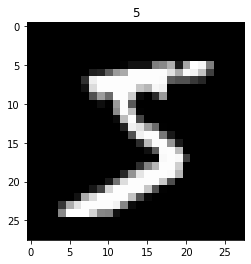

In [4]:
image, label = train_data[0]
print('-'*10, 'Image', '-'*10)
print(image[0][6])
print('-'*10, 'Label', '-'*10)
print(label)
plt.imshow(image.squeeze().numpy(), cmap = 'gray')
plt.title('%i' % label)
plt.show()

In [5]:
#MNIST Dataset (with standardization)
standardizer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5), std = (0.5))
])

train_data = dsets.MNIST(root = 'data/', train = True, transform = standardizer, download = True)
test_data = dsets.MNIST(root = 'data/', train = False, transform = standardizer, download = True)

print('train : ', len(train_data))
print('test : ', len(test_data))

train :  60000
test :  10000


---------- Image ----------
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.7647, -0.7176, -0.2627,  0.2078,  0.3333,  0.9843,  0.9843,  0.9843,
         0.9843,  0.9843,  0.7647,  0.3490,  0.9843,  0.8980,  0.5294, -0.4980,
        -1.0000, -1.0000, -1.0000, -1.0000])
---------- Label ----------
5


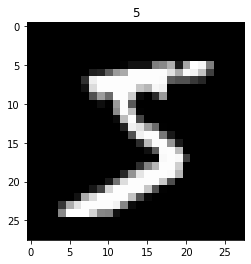

In [6]:
image, label = train_data[0]
print('-'*10, 'Image', '-'*10)
print(image[0][6])
print('-'*10, 'Label', '-'*10)
print(label)
plt.imshow(image.squeeze().numpy(), cmap = 'gray')
plt.title('%i' % label)
plt.show()

# CNN + Dropout + Batchnorm

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.conv_layer = nn.Sequential(
            #Conv block 1
            nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            #Conv Block 2
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout2d(p = 0.5),
            nn.Linear(128*3*3, 625),
            nn.ReLU(inplace = True),
            nn.Linear(625, 10)
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)  #flatten
        x = self.fc_layer(x)
        return x
    
classifier = Classifier()

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(classifier):,} trainable parameters. \n')

print(classifier)

The model has 819,749 trainable parameters. 

Classifier(
  (conv_layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Dropout2d(p=0.5, inplace=False)
    (1): Linear(in_features=1152, out_features=625, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=625, out_features=10

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr = 0.001)

In [10]:
batch_size = 1000

data_loader = torch.utils.data.DataLoader(dataset=train_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True,
                                         num_workers = 4)

In [11]:
classifier.to(DEVICE)
optimizer
criterion.to(DEVICE)

print('==> Start Training ...')

train_loss = []

for epoch in range(30):

    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        # get the inputs
        inputs = data[0].float().to(DEVICE)
        labels = data[1].to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        prediction = outputs.data.max(1)[1]
        # print statistics
        running_loss += loss.item()
#         if i%1000 == 999: #1000 mini batch마다 결과 출력
#             print('[%d, %5d] loss : %.3f'% ( epoch+1, i+1, running_loss/1000))
#             train_loss.append(running_loss/1000)
#             running_loss = 0.0
        print('[%d, %5d] loss : %.3f'% ( epoch+1, i+1, running_loss))
        train_loss.append(running_loss)
        running_loss = 0.0
    
    
print('==> Finished Training ...')

==> Start Training ...
[1,     1] loss : 2.328
[1,     2] loss : 2.333
[1,     3] loss : 2.321
[1,     4] loss : 2.327
[1,     5] loss : 2.311
[1,     6] loss : 2.308
[1,     7] loss : 2.323
[1,     8] loss : 2.313
[1,     9] loss : 2.324
[1,    10] loss : 2.325
[1,    11] loss : 2.325
[1,    12] loss : 2.323
[1,    13] loss : 2.317
[1,    14] loss : 2.314
[1,    15] loss : 2.315
[1,    16] loss : 2.311
[1,    17] loss : 2.305
[1,    18] loss : 2.310
[1,    19] loss : 2.321
[1,    20] loss : 2.311
[1,    21] loss : 2.304
[1,    22] loss : 2.305
[1,    23] loss : 2.302
[1,    24] loss : 2.303
[1,    25] loss : 2.308
[1,    26] loss : 2.299
[1,    27] loss : 2.296
[1,    28] loss : 2.302
[1,    29] loss : 2.312
[1,    30] loss : 2.309
[1,    31] loss : 2.308
[1,    32] loss : 2.305
[1,    33] loss : 2.302
[1,    34] loss : 2.301
[1,    35] loss : 2.304
[1,    36] loss : 2.293
[1,    37] loss : 2.307
[1,    38] loss : 2.293
[1,    39] loss : 2.299
[1,    40] loss : 2.298
[1,    41] loss :

[6,    41] loss : 2.141
[6,    42] loss : 2.153
[6,    43] loss : 2.144
[6,    44] loss : 2.146
[6,    45] loss : 2.135
[6,    46] loss : 2.141
[6,    47] loss : 2.140
[6,    48] loss : 2.138
[6,    49] loss : 2.136
[6,    50] loss : 2.132
[6,    51] loss : 2.142
[6,    52] loss : 2.149
[6,    53] loss : 2.132
[6,    54] loss : 2.133
[6,    55] loss : 2.134
[6,    56] loss : 2.138
[6,    57] loss : 2.132
[6,    58] loss : 2.136
[6,    59] loss : 2.135
[6,    60] loss : 2.142
[7,     1] loss : 2.134
[7,     2] loss : 2.138
[7,     3] loss : 2.126
[7,     4] loss : 2.136
[7,     5] loss : 2.135
[7,     6] loss : 2.128
[7,     7] loss : 2.134
[7,     8] loss : 2.128
[7,     9] loss : 2.138
[7,    10] loss : 2.125
[7,    11] loss : 2.136
[7,    12] loss : 2.129
[7,    13] loss : 2.131
[7,    14] loss : 2.123
[7,    15] loss : 2.126
[7,    16] loss : 2.118
[7,    17] loss : 2.122
[7,    18] loss : 2.119
[7,    19] loss : 2.127
[7,    20] loss : 2.123
[7,    21] loss : 2.113
[7,    22] loss 

[12,    16] loss : 1.859
[12,    17] loss : 1.851
[12,    18] loss : 1.853
[12,    19] loss : 1.849
[12,    20] loss : 1.851
[12,    21] loss : 1.845
[12,    22] loss : 1.813
[12,    23] loss : 1.846
[12,    24] loss : 1.844
[12,    25] loss : 1.838
[12,    26] loss : 1.836
[12,    27] loss : 1.823
[12,    28] loss : 1.827
[12,    29] loss : 1.828
[12,    30] loss : 1.836
[12,    31] loss : 1.822
[12,    32] loss : 1.823
[12,    33] loss : 1.839
[12,    34] loss : 1.832
[12,    35] loss : 1.833
[12,    36] loss : 1.814
[12,    37] loss : 1.825
[12,    38] loss : 1.825
[12,    39] loss : 1.828
[12,    40] loss : 1.814
[12,    41] loss : 1.803
[12,    42] loss : 1.817
[12,    43] loss : 1.810
[12,    44] loss : 1.815
[12,    45] loss : 1.828
[12,    46] loss : 1.792
[12,    47] loss : 1.812
[12,    48] loss : 1.812
[12,    49] loss : 1.818
[12,    50] loss : 1.800
[12,    51] loss : 1.812
[12,    52] loss : 1.796
[12,    53] loss : 1.790
[12,    54] loss : 1.800
[12,    55] loss : 1.805


[17,    43] loss : 1.349
[17,    44] loss : 1.332
[17,    45] loss : 1.356
[17,    46] loss : 1.340
[17,    47] loss : 1.343
[17,    48] loss : 1.363
[17,    49] loss : 1.347
[17,    50] loss : 1.342
[17,    51] loss : 1.339
[17,    52] loss : 1.307
[17,    53] loss : 1.330
[17,    54] loss : 1.331
[17,    55] loss : 1.338
[17,    56] loss : 1.352
[17,    57] loss : 1.341
[17,    58] loss : 1.341
[17,    59] loss : 1.309
[17,    60] loss : 1.317
[18,     1] loss : 1.330
[18,     2] loss : 1.307
[18,     3] loss : 1.304
[18,     4] loss : 1.327
[18,     5] loss : 1.335
[18,     6] loss : 1.341
[18,     7] loss : 1.298
[18,     8] loss : 1.332
[18,     9] loss : 1.294
[18,    10] loss : 1.299
[18,    11] loss : 1.269
[18,    12] loss : 1.308
[18,    13] loss : 1.306
[18,    14] loss : 1.295
[18,    15] loss : 1.294
[18,    16] loss : 1.319
[18,    17] loss : 1.322
[18,    18] loss : 1.305
[18,    19] loss : 1.300
[18,    20] loss : 1.317
[18,    21] loss : 1.256
[18,    22] loss : 1.323


[23,    10] loss : 0.909
[23,    11] loss : 0.908
[23,    12] loss : 0.927
[23,    13] loss : 0.906
[23,    14] loss : 0.892
[23,    15] loss : 0.905
[23,    16] loss : 0.877
[23,    17] loss : 0.888
[23,    18] loss : 0.909
[23,    19] loss : 0.899
[23,    20] loss : 0.932
[23,    21] loss : 0.883
[23,    22] loss : 0.909
[23,    23] loss : 0.920
[23,    24] loss : 0.949
[23,    25] loss : 0.916
[23,    26] loss : 0.916
[23,    27] loss : 0.884
[23,    28] loss : 0.899
[23,    29] loss : 0.907
[23,    30] loss : 0.909
[23,    31] loss : 0.871
[23,    32] loss : 0.891
[23,    33] loss : 0.899
[23,    34] loss : 0.897
[23,    35] loss : 0.921
[23,    36] loss : 0.901
[23,    37] loss : 0.895
[23,    38] loss : 0.910
[23,    39] loss : 0.884
[23,    40] loss : 0.863
[23,    41] loss : 0.846
[23,    42] loss : 0.917
[23,    43] loss : 0.893
[23,    44] loss : 0.875
[23,    45] loss : 0.886
[23,    46] loss : 0.872
[23,    47] loss : 0.879
[23,    48] loss : 0.890
[23,    49] loss : 0.888


[28,    37] loss : 0.698
[28,    38] loss : 0.670
[28,    39] loss : 0.691
[28,    40] loss : 0.631
[28,    41] loss : 0.694
[28,    42] loss : 0.689
[28,    43] loss : 0.679
[28,    44] loss : 0.686
[28,    45] loss : 0.737
[28,    46] loss : 0.659
[28,    47] loss : 0.728
[28,    48] loss : 0.663
[28,    49] loss : 0.695
[28,    50] loss : 0.694
[28,    51] loss : 0.657
[28,    52] loss : 0.672
[28,    53] loss : 0.635
[28,    54] loss : 0.639
[28,    55] loss : 0.673
[28,    56] loss : 0.662
[28,    57] loss : 0.670
[28,    58] loss : 0.653
[28,    59] loss : 0.633
[28,    60] loss : 0.682
[29,     1] loss : 0.670
[29,     2] loss : 0.653
[29,     3] loss : 0.641
[29,     4] loss : 0.671
[29,     5] loss : 0.655
[29,     6] loss : 0.669
[29,     7] loss : 0.665
[29,     8] loss : 0.651
[29,     9] loss : 0.666
[29,    10] loss : 0.657
[29,    11] loss : 0.686
[29,    12] loss : 0.668
[29,    13] loss : 0.694
[29,    14] loss : 0.663
[29,    15] loss : 0.658
[29,    16] loss : 0.677


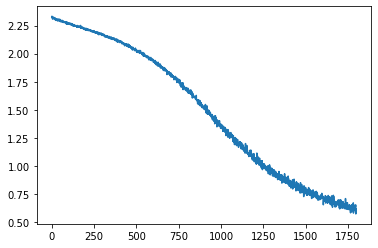

In [12]:
plt.plot(np.arange(len(train_loss)), train_loss)

In [13]:
batch_size = 1000

testloader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True,
                                         num_workers = 4)

In [29]:
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images = data[0].float().to(DEVICE)
        labels = data[1].to(DEVICE)
        outputs = classifier(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 85 %
Accuracy of     0 : 91 %
Accuracy of     1 : 97 %
Accuracy of     2 : 83 %
Accuracy of     3 : 80 %
Accuracy of     4 : 90 %
Accuracy of     5 : 73 %
Accuracy of     6 : 89 %
Accuracy of     7 : 87 %
Accuracy of     8 : 69 %
Accuracy of     9 : 84 %
